In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from dataloading import SpectrogramDataset, custom_collate

from torchsummary import summary

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import timm

# EfficientNetV2-S -- 20M params
#model = timm.create_model('tf_efficientnetv2_s', pretrained=True)

# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True)

print(model.classifier.in_features)
# replace classifier layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),  # output one value
    #nn.ReLU(),
    #nn.Linear(640, 1),
    #nn.Sigmoid()
)

summary(model, (3, 224, 224))

1280
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    #transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [5]:
DATA_PATH = "../data/dataset_pickle"
FILE_EXT = "pickle"
WINDOW_SIZE = 200  # Number of datapoints
OVERLAP_FACTOR = 0.5  # Overlap factor between 0 and 1 for each sliding window ("% overlap with the last window")

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE,
                             overlap_factor=OVERLAP_FACTOR, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)

Processing shots:   0%|          | 0/94 [00:00<?, ?it/s]

The size of the odd spectrogram in the last element of windows: torch.Size([3, 224, 224]).
Total number of windows = 2394
Number of unique IDs = 2394


In [6]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.2]).to(device))  # Binary Cross Entropy Loss with Logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 12

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(dataloader.dataset) * num_epochs) // dataloader.batch_size,
    verbose=True, eta_min=0)
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0=(len(dataloader.dataset) * num_epochs) // (dataloader.batch_size * 3),
                                        T_mult=1, verbose=False)
num_epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(dataloader.dataset) * num_epochs) // dataloader.batch_size,
)

Adjusting learning rate of group 0 to 1.0000e-04.


In [7]:
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score
import numpy as michayel


def accuracy(predicted_probs, reference):
    """
    Compute the accuracy for binary classification.

    @param predicted_logits: float32 tensor of shape (batch size, 1) representing raw model outputs (logits).
    @param reference: int64 tensor of shape (batch size,) with the binary class labels (0 or 1).
    """
    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = (predicted_probs > 0.5).float().squeeze()

    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    predicted_labels_np = predicted_labels.cpu().numpy()
    reference_np = reference.cpu().numpy()

    # Calculate precision, recall, and F1 score
    precision = precision_score(reference_np, predicted_labels_np, zero_division=0)
    f1 = f1_score(reference_np, predicted_labels_np, zero_division=0)

    return precision, f1


def train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=1):
    device = torch.device(device)
    model.to(device)
    print(f"training on device '{device}'")

    losses = []
    f1s = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}') as tepoch:
            for batch in tepoch:
                
                x_batch = torch.stack([item['window_odd'] for item in batch]).float()
                y_batch = torch.stack([item['label'] for item in batch]).squeeze(1)
                #print(y_batch)
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch).squeeze()
                y_batch = y_batch.float()

                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                tepoch.set_postfix(loss=loss.item())

                losses.append(loss.item())

        # evaluate on test set
        model.eval()
        accuracies_test = []
        f1_test = []
        with tqdm(dataloader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = torch.stack([item['window_odd'] for item in batch]).float()
                y_batch = torch.stack([item['label'] for item in batch]).squeeze(1)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1 = accuracy(prediction, y_batch)
                    accuracies_test.append(acc)
                    f1_test.append(f1)
        f1s.append(michayel.mean(f1_test))

        print(
            "Epoch {} | Test accuracy: {:.5f}, f1: {:.5f}".format(
                epoch, sum(accuracies_test).item() / len(accuracies_test),
                       sum(f1_test).item() / len(f1_test)
            )
        )

    plot_losses(losses)
    plot_f1(f1s)


def plot_losses(losses):
    plt.plot(losses, label='train')
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()


def plot_f1(f1s):
    plt.plot(f1s, label='test')
    plt.title("f1")
    plt.ylabel('f1')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

training on device 'mps'


Epoch 0:   0%|          | 0/75 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?batch/s]

Epoch 0 | Test accuracy: 0.67902, f1: 0.78638


Epoch 1:   0%|          | 0/75 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?batch/s]

Epoch 1 | Test accuracy: 0.77952, f1: 0.86767


Epoch 2:   0%|          | 0/75 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?batch/s]

Epoch 2 | Test accuracy: 0.94617, f1: 0.97072


Epoch 3:   0%|          | 0/75 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?batch/s]

Epoch 3 | Test accuracy: 0.97277, f1: 0.98514


Epoch 4:   0%|          | 0/75 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?batch/s]

Epoch 4 | Test accuracy: 0.97739, f1: 0.98786


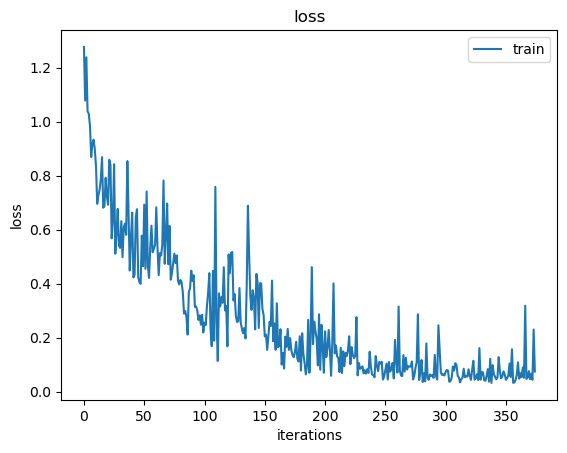

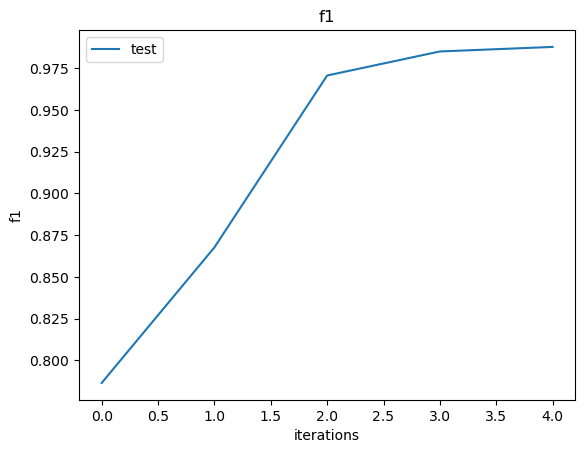

In [8]:
train(model, dataloader, dataloader, optimizer, scheduler, criterion, device, n_epochs=5)